In [0]:
import pandas as pd
import numpy as np
import lightgbm as lgb

import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import TimeSeriesSplit, KFold

In [0]:
features_to_take = ['TransactionID', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3',
                    'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain',
                    'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D2',
                    'D3', 'D4', 'D5', 'D10', 'D11', 'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1',
                    'V3', 'V5', 'V7', 'V11', 'V13', 'V14', 'V16', 'V20', 'V24', 'V26', 'V28', 'V30', 'V35', 'V36',
                    'V38', 'V40', 'V41', 'V45', 'V47', 'V49', 'V54', 'V55', 'V56', 'V58', 'V62', 'V65', 'V67', 'V68',
                    'V70', 'V76', 'V78', 'V80', 'V83', 'V87', 'V88', 'V89', 'V91', 'V107', 'V110', 'V112', 'V119',
                    'V121', 'V122', 'V125', 'V131', 'V138', 'V140', 'V142', 'V145', 'V147', 'V162', 'V169', 'V173', 
                    'V174', 'V185', 'V195', 'V210', 'V216', 'V220', 'V222', 'V241', 'V251', 'V271', 'V280', 'V281',
                    'V283', 'V284', 'V286', 'V287', 'V289', 'V291', 'V301', 'V303', 'V305', 'V311', 'V314', 'V323',
                    'V325', 'V335']

features_to_take_id = ['TransactionID', 'id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_09', 'id_10',
                       'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20',
                       'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37',
                       'id_38', 'DeviceType', 'DeviceInfo']

# ID attributes in 
features_to_take_id_test = [feature.replace('_', '-') for feature in features_to_take_id]

# Mention features encoded to a particular dtype
string_features_train = ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M4', 'id_12', 'id_15',
                         'id_16', 'id_28', 'id_29', 'id_30', 'id_31', 'id_33', 'id_34', 'DeviceType', 'DeviceInfo']

string_features_test = [feature.replace('_', '-') for feature in string_features_train]

boolean_features = ['M' + str(i) for i in range(1, 10) if i != 4] + ['id_' + str(i) for i in range(35, 39)]


In [0]:
# Read train and test dataset
train_df = pd.read_csv('../dataset/train_transaction.csv', usecols=features_to_take + ['isFraud'])
test_df = pd.read_csv('../dataset/test_transaction.csv', usecols=features_to_take)

train_df_id = pd.read_csv('../dataset/train_identity.csv', usecols=features_to_take_id)
test_df_id = pd.read_csv('../dataset/test_identity.csv', usecols=features_to_take_id_test)

# Left join dataset
train_df = train_df.merge(right=train_df_id, how='left', on='TransactionID')
test_df = test_df.merge(right=test_df_id, how='left', on='TransactionID')

In [0]:
renaming_mapper = dict(zip(features_to_take_id_test, features_to_take_id))
test_df.rename(mapper=renaming_mapper, axis='columns', inplace=True)

In [0]:

le = preprocessing.LabelEncoder()

concat_df = pd.concat([train_df, test_df])

for feature in string_features_train:
    train_df[feature] = train_df[feature].astype('str')
    test_df[feature] = test_df[feature].astype('str')
    concat_df[feature] = concat_df[feature].astype('str')
    le.fit(concat_df[feature])
    train_df[feature] = le.fit_transform(train_df[feature])
    test_df[feature] = le.fit_transform(test_df[feature])
    
for feature in boolean_features:
    train_df[feature] = train_df[feature].astype('bool')
    test_df[feature] = test_df[feature].astype('bool')

In [0]:
train_df.head(n=4)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D2,D3,D4,D5,D10,D11,D15,M1,M2,...,V291,V301,V303,V305,V311,V314,V323,V325,V335,id_01,id_02,id_03,id_04,id_05,id_06,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,4,13926,NaN,150.0,1,142.0,1,315.0,87.0,19.0,NaN,32,32,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,NaN,13.0,NaN,NaN,13.0,13.0,0.0,True,True,...,1.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,3,2,NaN,NaN,NaN,NaN,2,2,74,103,NaN,260,4,True,True,True,True,2,1742
1,2987001,0,86401,29.0,4,2755,404.0,150.0,2,102.0,1,325.0,87.0,NaN,NaN,16,32,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,NaN,NaN,0.0,NaN,0.0,NaN,0.0,True,True,...,1.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,3,2,NaN,NaN,NaN,NaN,2,2,74,103,NaN,260,4,True,True,True,True,2,1742
2,2987002,0,86469,59.0,4,4663,490.0,150.0,4,166.0,2,330.0,87.0,287.0,NaN,36,32,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,NaN,NaN,0.0,NaN,0.0,315.0,315.0,True,True,...,1.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,3,2,NaN,NaN,NaN,NaN,2,2,74,103,NaN,260,4,True,True,True,True,2,1742
3,2987003,0,86499,50.0,4,18132,567.0,150.0,2,117.0,2,476.0,87.0,NaN,NaN,54,32,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,0.0,94.0,0.0,84.0,NaN,111.0,True,True,...,1.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,3,2,NaN,NaN,NaN,NaN,2,2,74,103,NaN,260,4,True,True,True,True,2,1742


In [0]:
test_df.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D2,D3,D4,D5,D10,D11,D15,M1,M2,M3,...,V291,V301,V303,V305,V311,V314,V323,V325,V335,id_01,id_02,id_03,id_04,id_05,id_06,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,3663549,18403224,31.95,4,10409,111.0,150.0,4,226.0,2,170.0,87.0,1.0,NaN,16,32,6.0,6.0,0.0,0.0,3.0,4.0,0.0,0.0,6.0,0.0,5.0,1.0,115.0,6.0,419.0,27.0,398.0,27.0,418.0,203.0,409.0,True,True,True,...,1.0,0.0,0.0,1.0,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,3,2,NaN,NaN,NaN,NaN,2,2,85,107,NaN,390,2,True,True,True,True,2,2184
1,3663550,18403263,49.00,4,4272,111.0,150.0,4,226.0,2,299.0,87.0,4.0,NaN,2,32,3.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,1.0,12.0,2.0,149.0,7.0,634.0,7.0,231.0,634.0,634.0,True,True,True,...,1.0,0.0,0.0,1.0,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,3,2,NaN,NaN,NaN,NaN,2,2,85,107,NaN,390,2,True,True,True,True,2,2184
2,3663551,18403310,171.00,4,4476,574.0,150.0,4,226.0,2,472.0,87.0,2635.0,NaN,19,32,2.0,2.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,2.0,0.0,22.0,2.0,137.0,10.0,97.0,10.0,136.0,136.0,97.0,True,True,True,...,2.0,0.0,0.0,1.0,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,3,2,NaN,NaN,NaN,NaN,2,2,85,107,NaN,390,2,True,True,True,True,2,2184
3,3663552,18403310,284.95,4,10989,360.0,150.0,4,166.0,2,205.0,87.0,17.0,NaN,16,32,5.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,2.0,0.0,7.0,4.0,42.0,41.0,242.0,41.0,242.0,242.0,242.0,True,True,True,...,1.0,0.0,0.0,1.0,0.000000,282.540009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,3,2,NaN,NaN,NaN,NaN,2,2,85,107,NaN,390,2,True,True,True,True,2,2184
4,3663553,18403317,67.95,4,18018,452.0,150.0,2,117.0,2,264.0,87.0,6.0,NaN,16,32,6.0,6.0,0.0,0.0,2.0,5.0,0.0,0.0,5.0,0.0,6.0,0.0,14.0,6.0,22.0,0.0,22.0,0.0,22.0,22.0,22.0,True,True,True,...,1.0,0.0,0.0,1.0,67.949997,183.850006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,3,2,NaN,NaN,NaN,NaN,2,2,85,107,NaN,390,2,True,True,True,True,2,2184


In [0]:
# From parameter tuning
params = {'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.006883242363721497,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc', #'rmse',
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
         }

In [0]:
# Generate K Fold Cross Validation
n_fold = 5
folds = TimeSeriesSplit(n_splits=n_fold)
folds = KFold(n_splits=5)

columns = train_df.columns

In [0]:
#KFold Cross Validation
for fold_n, (train_index, valid_index) in enumerate(folds.split(train_df)):
    if type(train_df) == np.ndarray:
        X_train, X_valid = train_df[columns][train_index], train_df[columns][valid_index]
    else:
        X_train, X_valid = train_df[columns].iloc[train_index], train_df[columns].iloc[valid_index]
    
    #print(X_train.groupby('isFraud').size().reset_index(name='Count'))
    train_data = lgb.Dataset(X_train.loc[:, X_train.columns != 'isFraud'], label=X_train['isFraud'])
    val_data = lgb.Dataset(X_valid.loc[:, X_valid.columns != 'isFraud'], label= X_valid['isFraud'])
    print("Fold " + str(fold_n))
    clf = lgb.train(params, train_data, 10000, valid_sets=[train_data, val_data], early_stopping_rounds=500, verbose_eval=300)
    

Fold 0
Training until validation scores don't improve for 500 rounds.
[300]	training's auc: 0.960548	valid_1's auc: 0.892863
[600]	training's auc: 0.982905	valid_1's auc: 0.908162
[900]	training's auc: 0.992201	valid_1's auc: 0.917124
[1200]	training's auc: 0.996163	valid_1's auc: 0.921397
[1500]	training's auc: 0.997949	valid_1's auc: 0.923017
[1800]	training's auc: 0.998848	valid_1's auc: 0.923598
[2100]	training's auc: 0.999341	valid_1's auc: 0.923601
[2400]	training's auc: 0.999647	valid_1's auc: 0.92335
Early stopping, best iteration is:
[1981]	training's auc: 0.99919	valid_1's auc: 0.92364
Fold 1
Training until validation scores don't improve for 500 rounds.
[300]	training's auc: 0.960093	valid_1's auc: 0.912768
[600]	training's auc: 0.983177	valid_1's auc: 0.925835
[900]	training's auc: 0.992826	valid_1's auc: 0.930926
[1200]	training's auc: 0.996746	valid_1's auc: 0.93296
[1500]	training's auc: 0.998451	valid_1's auc: 0.933867
[1800]	training's auc: 0.99923	valid_1's auc: 0.933

Best Fold is Fold 3 (from 0 to 4)

In [0]:
model  = lgb.LGBMClassifier(
          num_leaves = 491,
          min_child_weight=0.03454472573214212,
          min_data_in_leaf=106,
          objective='binary',
          max_depth=-1,
          learning_rate= 0.01,
          boosting_type="gbdt",
          subsample=0.3797454081646243,
          random_state = 47,
          n_estimators=2000,
          reg_alpha= 0.3899927210061127,
          reg_lambda= 0.6485237330340494,
          )

idx = [(train_index, valid_index) for fold_n, (train_index, valid_index) in enumerate(folds.split(train_df))][3]
if type(train_df) == np.ndarray:
    X_train, X_valid = train_df[columns][idx[0]], train_df[columns][idx[1]]
else:
    X_train, X_valid = train_df[columns].iloc[idx[0]], train_df[columns].iloc[idx[1]]

train_data = lgb.Dataset(X_train.loc[:, X_train.columns != 'isFraud'], label=X_train['isFraud'])
val_data = lgb.Dataset(X_valid.loc[:, X_valid.columns != 'isFraud'], label= X_valid['isFraud'])
# Model Training
clf = lgb.train(params, train_data, 10000, valid_sets=[train_data, val_data], early_stopping_rounds=500, verbose_eval=300)

Training until validation scores don't improve for 500 rounds.
[300]	training's auc: 0.959198	valid_1's auc: 0.926278
[600]	training's auc: 0.983234	valid_1's auc: 0.941798
[900]	training's auc: 0.992785	valid_1's auc: 0.94737
[1200]	training's auc: 0.996696	valid_1's auc: 0.948837
[1500]	training's auc: 0.998442	valid_1's auc: 0.949239
[1800]	training's auc: 0.999225	valid_1's auc: 0.949174
[2100]	training's auc: 0.999598	valid_1's auc: 0.948876
Early stopping, best iteration is:
[1708]	training's auc: 0.999055	valid_1's auc: 0.949272


In [0]:
f = clf.predict(test_df.loc[:, test_df.columns != 'isFraud'])

Submission Purposes

In [0]:
g = clf.predict(X_valid.loc[:, X_valid.columns != 'isFraud'])

118108


<Figure size 432x288 with 0 Axes>

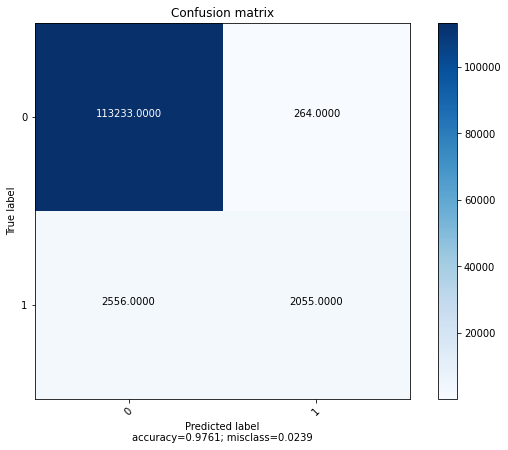

In [0]:
from sklearn.metrics import confusion_matrix
g_bin = 1*(g>0.5)
print(len(g_bin))
unique, counts = np.unique(g_bin, return_counts=True)
cm = confusion_matrix (X_valid['isFraud'], g_bin)
plt.figure()
plot_confusion_matrix(cm, [0,1])
plt.show()

In [0]:

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if not normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [0]:
result_df = pd.DataFrame({
    "TransactionID": test_df.TransactionID, 
    "isFraud": f})

In [0]:
result_df.to_csv("lgbm.csv", index=false)

Not used

In [0]:
h = model.fit(X_train.loc[:, X_train.columns != 'isFraud'], X_train['isFraud'], 
        eval_set=[(X_valid.loc[:, X_valid.columns != 'isFraud'], X_valid['isFraud'])],
        verbose=200, early_stopping_rounds=500, eval_metric = 'auc')

In [0]:
from bayes_opt import BayesianOptimization